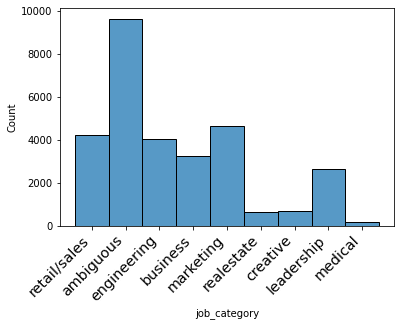

In [54]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

data = pd.read_csv('./data/data_augmented.csv')

ax = sns.histplot(data['job_category'])
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)
#ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

In [55]:
import numpy as np
import math

data = pd.read_csv('./data/data_augmented.csv', encoding="utf8")

In [56]:
import pandas as pd
import numpy as np
import bs4 as bs

# load terms
masc_terms = pd.read_csv('./terms/terms_m.csv', header=None)
fem_terms = pd.read_csv('./terms/terms_f.csv', header=None)

# load postings
data = pd.read_csv('./data/data_augmented.csv')
stop_words = pd.read_csv('./terms/stopwords.csv', header=None)
j = len(data['job_description'])

# build the corpus from normalized job postings
# parse/remove HTML tokens
# make all tokens lowercase
corpus = []
sw = []
for word in stop_words[0].array:
    sw.append(word)

for i in range(j):
    jd = data['job_description'][i]
    jd_cleaned = bs.BeautifulSoup(jd, features="html.parser")
    jd_final = jd_cleaned.get_text().lower()
    corpus.append(jd_final)

from sklearn.feature_extraction.text import CountVectorizer

# tokenize job postings
# to compute tf-idf I ignored terms that showed up in less than 0.05% and 
# terms that showed up in more than 99.95% of job descriptions.
# I also built a stopwords list of terms using the following:
# - job description headers (e.g. "Essential Job Requirements:")
# - standard english stopwords from NLTK
# - numerical tokens that appeared in job postings more than 0.05% percent of the time (e.g. "95834")
# Complete list of stopwords is provided in `/data` directory
vectorizer = CountVectorizer(stop_words=frozenset(sw), min_df=0.0005, max_df=0.9995)
X = vectorizer.fit_transform(corpus)

# get mapping
mapping = vectorizer.get_feature_names()
masc_idx = []
fem_idx = []
for i in range(len(mapping)):
    for m in masc_terms[0]:
        if mapping[i].startswith(m):
            masc_idx.append(i)

    for f in fem_terms[0]:
        if mapping[i].startswith(f):
            fem_idx.append(i)

matrix = np.array(X.toarray())


In [57]:
totalTermsPerJD = matrix.sum(axis=1)
totalMascTermsPerJD = matrix[:,np.array(masc_idx)].sum(axis=1)
totalFemTermsPerJD = matrix[:,np.array(fem_idx)].sum(axis=1)
totalFrequencyPerTerm = matrix.sum(axis=0)
docMascFrequency = ((matrix[:,np.array(masc_idx)] != 0).sum(axis=1) != 0).sum()
docFemFrequency = ((matrix[:,np.array(fem_idx)] != 0).sum(axis=1) != 0).sum()
features = np.array(vectorizer.get_feature_names())

labels = features[np.array(fem_idx)]

masc = (totalMascTermsPerJD/totalTermsPerJD)/np.log(30002/(docMascFrequency))
fem = (totalFemTermsPerJD/totalTermsPerJD)/np.log(30002/(docFemFrequency))
male_dominant = masc > fem

data['masc'] = masc
data['fem'] = fem
data['male_dominant'] = male_dominant

In [59]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
import numpy as np

df = data[data['job_category'] != 'ambiguous']
oneWayModel = stats.kruskal(df[df['job_category'] == 'business']['masc'], df[df['job_category'] == 'retail/sales']['masc'], df[df['job_category'] == 'engineering']['masc'])

print(oneWayModel)
print('Mean number of masculine terms in Business: ' + str(np.mean(df[df['job_category'] == 'business']['masc'])))
print('Mean number of feminine terms in Business: ' + str(np.mean(df[df['job_category'] == 'business']['fem'])))
print('Mean number of masculine terms in Engineering: ' + str(np.mean(df[df['job_category'] == 'engineering']['masc'])))
print('Mean number of feminine terms in Engineering: ' + str(np.mean(df[df['job_category'] == 'engineering']['fem'])))
print('Mean number of masculine terms in Retail: ' + str(np.mean(df[df['job_category'] == 'retail/sales']['masc'])))
print('Mean number of feminine terms in Retail: ' + str(np.mean(df[df['job_category'] == 'retail/sales']['fem'])))
print('Mean number of masculine terms in Marketing: ' + str(np.mean(df[df['job_category'] == 'marketing']['masc'])))
print('Mean number of feminine terms in Marketing: ' + str(np.mean(df[df['job_category'] == 'marketing']['fem'])))

# calculate if the posting uses male dominant language
df['male_dominant'] = df['masc'] > df['fem']

masc_model = ols('masc ~ C(job_category) + C(male_dominant) + C(job_category):C(male_dominant)', data=df).fit()
fem_model = ols('fem ~ C(job_category) + C(male_dominant) + C(job_category):C(male_dominant)', data=df).fit()

sm.stats.anova_lm(masc_model, typ=2)

KruskalResult(statistic=174.9796121007889, pvalue=1.0084630945846613e-38)
Mean number of masculine terms in Business: 0.520349785449537
Mean number of feminine terms in Business: 0.3789192355198133
Mean number of masculine terms in Engineering: 0.48324614440202707
Mean number of feminine terms in Engineering: 0.40991399077366575
Mean number of masculine terms in Retail: 0.4279387821083323
Mean number of feminine terms in Retail: 0.3385325170192991
Mean number of masculine terms in Marketing: 0.5903631897691002
Mean number of feminine terms in Marketing: 0.3696068505834933


,sum_sq,df,F,PR(>F)
C(job_category),103.943578,7.0,218.945168,5.485399e-315
C(male_dominant),476.319122,1.0,7023.179336,0.000000e+00
C(job_category):C(male_dominant),6.938329,7.0,14.614791,4.048857e-19
Residual,1380.903603,20361.0,NaN,NaN


# Motivation  

Multiple studies have suggested that the language we use in hiring influences the audience we are trying to reach and in turn influences the individuals who are hired. The goal for this project is to identify linguistic patterns that have bias in online job postings. The scope of this project is to reproduce research to determine if male/female dominated jobs container gender specific language that could deter applicants. 

# Related Work 

Hiring practices are what drives economic equity and gender equality. As such recruiters and hiring managers are gatekeepers with the opportunity to affect the people we work with. However, multiple people have been looking at a part of the pipeline which is often ignored: Both companies and individuals have looked at this problem before including [Textio](https://textio.com/blog/avoiding-harmful-language-in-hiring-content/34152146534) and [Jieyu Zhao](https://arxiv.org/abs/1707.09457). Textio builds products to identify writing that contains strong tone that may affect the audience job description authors are trying to reach out to. Jieyu is a Microsoft fellowship recipient who has published numerous papers on identifying gender bias in corpora and how to compensate when training models. 

[University of Waterloo and Duke](https://www.paycor.com/resource-center/gender-discrimination-in-job-descriptions) also conducted a study of 96 individuals who looked at 6 job postings where 2 were written using terms and phrases that were considered “more masculine” and 2 were written using “more feminine” terms. The remaining two were neutral in wording. The conclusion of the study was that women were more likely not to apply to the positions that contained more masculine phrasing. 

# Data  

The dataset consists of 30,000 US job postings that were posted publicly through the website Indeed. The data was extracted by a web content scraping company called PromptCloud and licensed as Public Domain.  

The data consists of job posts from August 1st, 2019 through October 31st, 2019. Each job post contains a natural language column for job description. The dataset is originally from a data repository [(link)](https://data.world/promptcloud/indeed-job-posting-dataset)  

It will be useful for comparing the terms used in the job post with the job title.  

I do not believe there are ethical concerns as this dataset was published publicly and the original data itself was available publicly on Indeed's website.  

# Research Questions 

1. What are the most frequently used words that are used in job postings on this dataset? Is there anything that sticks out or seems like it may not generalize about job postings outside of the US? Could this introduce a bias if used outside of the US? 

2. What is the distribution of different job titles on this dataset? How many are considered stereotypically masculine or feminine? 

3. Is there a difference in the mean number of masculine and feminine terms for jobs that are sterrotypically more masculine and feminine respectively? 

# Methodology 

To perform this analysis, I will be using a set of terms that were defined by the University of Waterloo and Duke as traditionally masculine and feminine phrases respectively. After preprocessing the text in the job descriptions, I want to compute if the mean number of traditionally masculine phrases is different for roles using t-tests. I would like to perform this on the larger dataset for individual categories of positions: 

- Engineering Roles 
- Administrative Roles 
- Healthcare Roles 